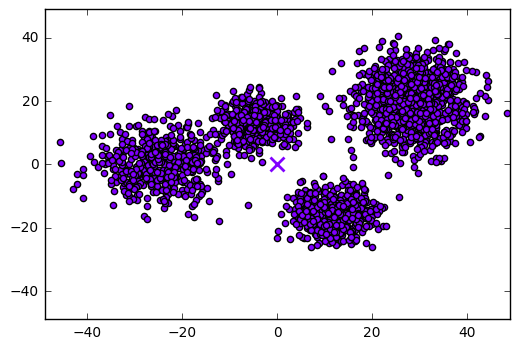

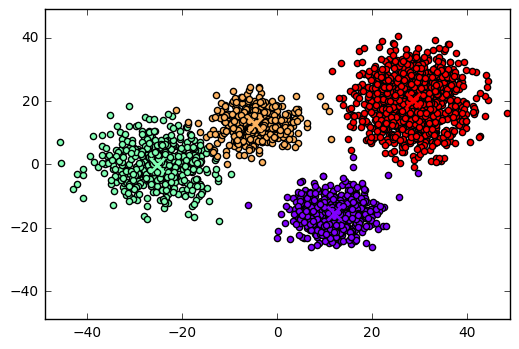

Best silhouette score: 0.771673798561
Centroids for optimal score:
[[ 11.90669155 -15.35458565]
 [         nan          nan]
 [-25.36264038  -0.15672994]
 [ -4.59063721  12.8771944 ]
 [ 28.59760475  20.2443924 ]]


In [157]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools

%matplotlib inline
g_max = 0.0    # Plot grid dimension. Global to calculate once.

def plot_clusters(partitions, centroids):
    
    # Get color map and create color array
    cmap = plt.cm.get_cmap('rainbow')
    color = cmap(np.linspace(0,1,len(partitions)))
    
    # Get grid size for plot
    global g_max
    if not g_max > 0.0:
        g_max = np.amax([math.ceil(np.amax(np.absolute(p))) for p in partitions])
    
    # Plot points in each partition and centroids
    for i, part in enumerate(partitions):     
        plt.scatter(part[:,0],part[:,1], c=color[i])
        plt.plot(centroids[i][0], centroids[i][1], markersize=10, marker="x", color=color[i], mew=2)
    
    axes = plt.gca()
    axes.set_xlim([-1*g_max,g_max])
    axes.set_ylim([-1*g_max,g_max])
    plt.show()

def generate_samples(n_clusters, n_per_cluster, n_features, seed):
    
    # Generate sample data for clustering
    clusters = []
    seeds = np.random.randint(low=0, high=seed, size=n_clusters)
    centers = [(np.random.randint(low=-30, high=30),np.random.randint(low=-30,high=30)) for n in range(n_clusters)]

    for i in range(n_clusters):
        np.random.seed(seeds[i])
        stddev = 3.0+np.random.random()*5.0
        samples = tf.random_normal((n_per_cluster, n_features), mean=0.0, stddev=stddev, dtype=tf.float32, seed=seeds[i], name="cluster_{}".format(i))
        shifted = tf.add(samples, centers[i], name="shifted_cluster_{}".format(i))
        clusters.append(shifted)

    samples = tf.concat(0, clusters, name='samples')
    shuffled = tf.random_shuffle(samples,name='shuffle')    
    
    return samples

def get_nearest(samples, centroids):
    
    # Determine closest centroid for each point
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    nearest_indices = mins
    return nearest_indices

def partition(samples, nearest_indices, n_clusters):
    
    # Partitions the samples into n_clusters using nearest_indices 
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    return partitions   

def update_centroids(partitions):
    
    # Calculates the centroid of each partition
    new_centroids = tf.concat(0, [tf.expand_dims(tf.reduce_mean(p, 0), 0) for p in partitions])
    return new_centroids

def get_random_points(n_points, n_dim, bounds):

    b = [float(val) for val in bounds]  
    points = [tuple([b[j]*np.random.random()*np.random.choice(a=[-1,1]) for j in range(n_dim)]) for i in range(n_points)]
    return points


def silhouette_score(partitions):
    # TODO: Handle empty partitions
    
    #Calculates the silhoutte score for a partitioning. Larger scores are better.    
    a = []
    for p in partitions:
        a_sq_diff = tf.square(tf.sub(tf.expand_dims(p,axis=0),tf.expand_dims(p,axis=1)))
        a.append(tf.reduce_mean(tf.reduce_sum(a_sq_diff,axis=2,name='intra1'),axis=1,name='intra2'))
    a = tf.concat(0,a,name='intra3')    # Intra-cluster distances
    
    col = []  
    for i, p1 in enumerate(partitions):
        c = []
        for j, p2 in enumerate(partitions):
            if not i == j:
                b_sq_diff = tf.square(tf.sub(tf.expand_dims(p2,axis=0),tf.expand_dims(p1,axis=1)))
                c.append(tf.reduce_mean(tf.reduce_sum(b_sq_diff,axis=2,name='inter1'),axis=1,name='inter2'))
        col.append(tf.reduce_min(tf.concat(1,tf.expand_dims(c,axis=1),name='inter3'),axis=0))
        
    b = tf.reshape(tf.concat(1,col,name='inter4'),[-1])     # Minimal inter-cluster distances
   
    numerator = tf.subtract(b,a)
    denominator = tf.maximum(a,b)
    ratio = tf.divide(numerator,denominator)
    s = tf.reduce_mean(ratio)
    
    return s

# Run parameters     
n_features = 2
n_clusters = 5
n_per_cluster = 500
seed = 314
n_tests_per_cluster_size = 50

# Feed variables
centroids = tf.placeholder(tf.float32, shape=(n_clusters,n_features))
sample_values = tf.placeholder(tf.float32, shape=(n_clusters*n_per_cluster,n_features))

# Derived variables
samples = generate_samples(n_clusters, n_per_cluster, n_features, seed)
nearest_indices = get_nearest(sample_values, centroids)
partitions = partition(sample_values, nearest_indices, n_clusters)
updated_centroids = update_centroids(partitions)
sil = silhouette_score(partitions)

last_sil_val = -1.0    # Initialize tracking variable for best silhouette score across initializations

model = tf.global_variables_initializer()
with tf.Session() as session:
    
    sample_vals = session.run(samples)
    plot_clusters([sample_vals],[[0,0]])

    for j in range(n_tests_per_cluster_size):
        centroids_value = get_random_points(n_clusters,n_features,[40,40])
        for i in range(5):
            partitions_value = session.run(partitions,feed_dict={centroids: centroids_value, sample_values: sample_vals})
            centroids_value = session.run(updated_centroids,feed_dict={centroids: centroids_value,sample_values: sample_vals})
        sil_val = session.run(sil,feed_dict={centroids: centroids_value, sample_values: sample_vals})
        if sil_val > last_sil_val:
            best_centroids = centroids_value
            last_sil_val = sil_val
            
    partitions_value = session.run(partitions,feed_dict={centroids: best_centroids, sample_values: sample_vals})
    plot_clusters(partitions_value,best_centroids)
    print 'Best silhouette score: {}'.format(sil_val)
    print 'Centroids for optimal score:'
    print best_centroids